In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import eli5
import shap
from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
from functions import save_features2, LabelEncoderPopularity,load_data
from lib.training import *

In [3]:
# data = pd.read_pickle('./pickles/data_all_features.pkl')
with pd.HDFStore('./hdf/Store.h5',complib='blosc:blosclz') as store:
    data = store['initial/encoded']
    categorial_features = list(store['initial/categorial_features'].values.flatten())
    numerical_features = list(store['initial/numerical_features'].values.flatten())
    numerical_features.sort()
    categorial_features.sort()

In [7]:
data['isTrain'] = 0
t = data['isTrain']
t[data['isFraud']>=0] = 1
data['isTrain'] = t

In [9]:
data.drop(['isFraud'],axis=1,inplace=True)

In [13]:
X = data.drop(['isTrain','Date'],axis=1)
y = data['isTrain']
 

In [14]:
n_fold = 5
folds = GroupKFold(n_splits=5)
with pd.HDFStore('./hdf/Store.h5',complib='blosc:blosclz') as store:
    groups = store['initial/card_id']

categorical_columns = [c for c, col in enumerate(X.columns) if col in categorial_features]

Fold 1 started at Sun Aug 11 19:34:45 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.973461	training's auc: 0.973461	valid_1's auc: 0.932323	valid_1's auc: 0.932323
[1000]	training's auc: 0.986659	training's auc: 0.986659	valid_1's auc: 0.943923	valid_1's auc: 0.943923
[1500]	training's auc: 0.991375	training's auc: 0.991375	valid_1's auc: 0.946217	valid_1's auc: 0.946217
Early stopping, best iteration is:
[1401]	training's auc: 0.990833	training's auc: 0.990833	valid_1's auc: 0.946411	valid_1's auc: 0.946411
Fold 2 started at Sun Aug 11 19:54:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.972493	training's auc: 0.972493	valid_1's auc: 0.951146	valid_1's auc: 0.951146
[1000]	training's auc: 0.986478	training's auc: 0.986478	valid_1's auc: 0.960477	valid_1's auc: 0.960477
[1500]	training's auc: 0.991721	training's auc: 0.991721	valid_1's auc: 0.963595	valid_1's auc: 0.963595
Early stopping, best

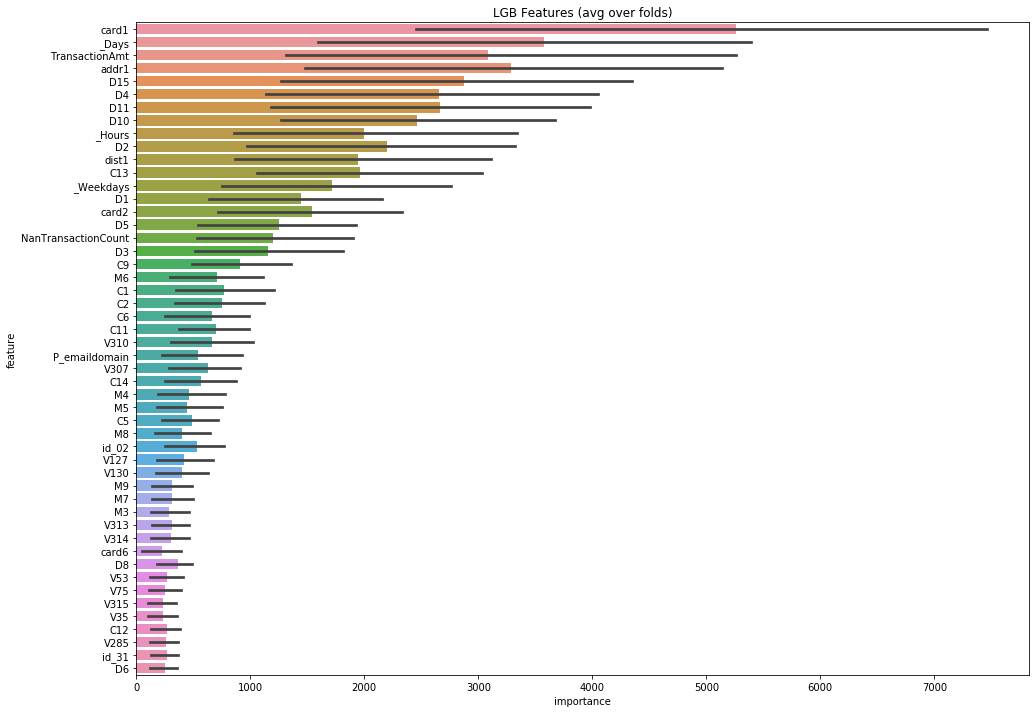

In [15]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'categorical_feature': categorical_columns,
#           'device': 'gpu'
         }
result_dict_lgb = train_model_classification(X=X, X_test=None, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1, groups=groups)